In [3]:
!pip install gymnasium
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 8.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 15.5 MB/s eta 0:00:00m eta 0:00:010:01:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 18.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.6 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 KB 23.1 MB/s eta 0:00:00


In [4]:
import gymnasium as gym
import matplotlib.pyplot as plt


# launch adventure environment with human rendering
env = gym.make("FrozenLake-v1")
env.reset()

number_of_actions = env.action_space.n

In [59]:

from llama_cpp import Llama
import numpy as np
import re


class LLM_Agent:

    def __init__(self):
        self.llm = Llama(model_path="../model/wizardLM-7B.ggmlv3.q4_1.bin", logits_all=True)

        # RL specific variables
        self.observations = []
        self.rewards = []


        self.memory = [] # extract previous epsiodes from game
        self.belief = [] # extract rules from game

    def set_action_space(self, action_space):
        self.action_space = action_space
        self.text_action_space = ', '.join(f"'{w}'" for w in action_space)
        print("action space: ", self.action_space)

    def get_action_prompt(self):
        prompt = (
            f"{self.character_prompt}"
            f"This is the current state of the board {self.observations[-1]}. "
            f"You can use the following actions: {self.text_action_space}. "
            f"Please output one of the possible actions. "
            f"If you are unsure, please output an action as you are learning how to use the controllers of this video game. "
            f"The selected action is: "
        )
        return prompt

    def set_character_prompt(self, character_prompt):
        self.character_prompt = character_prompt

    def generate(self, prompt):
        return self.llm(f"""{prompt}""", echo=True)
    
    def save_observation(self, observation):
        self.observations.append(observation)

    def save_reward(self, reward):
        self.rewards.append(reward)
    
    def generate_action(self, debug=False):

        prompt = self.get_action_prompt()
        print(f"get_action_prompt: {prompt}")

        # TODO check actions are valid
        output = self.generate(prompt)
        print(f"generated output: {output}")
        
        generated_text = output['choices'][0]['text']
        
        # Find the direction chosen by the LLM_agent
        generated_direction = re.search("'([^']+)'", generated_text)
        print(f"Generated direction: {generated_direction.group(1)}")


        # TODO beam search would be better here or using raw logits
        

        # for all actions in action space check at which index it appears in the generated text
        # the action with the lowest index is the action we want to take
        text_index = 1000
        action_number = -1
        for i, current_action in enumerate(self.action_space):

            action_index = generated_text.find(current_action)
            
            if action_index != -1 and action_index < text_index:
                text_index = action_index
                action_number = i
                

        if action_number == -1:
            # raise Exception("No action found in generated text")
            # print warning in red
            print("\033[91mNo action found in generated text\033[0m")
            # randomly select action
            action_number = np.random.randint(0, len(self.action_space))
        
        return action_number
    


In [191]:
# Some random notes / ideas

# multiple model controller, critic
# queue and planning
# long term memory 
# react 
# https://github.com/luca-medeiros/lang-segment-anything
# autonomous agents text us back if does know what to do and learn from it

In [60]:
# Your a video game player, your goal is to get the key and get out of the dungeon

agent = LLM_Agent()

env.action_space

# how can we get the agent to learn the action space
agent.set_action_space(["left", "down", "right", "up"])

agent.set_character_prompt("You are a video game player.")

llama.cpp: loading model from ../model/wizardLM-7B.ggmlv3.q4_1.bin
llama_model_load_internal: format     = ggjt v3 (latest)
llama_model_load_internal: n_vocab    = 32001
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 3 (mostly Q4_1)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size =    0.07 MB
llama_model_load_internal: mem required  = 5809.34 MB (+ 1026.00 MB per state)


action space:  ['left', 'down', 'right', 'up']


.
llama_init_from_file: kv self size  =  256.00 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | VSX = 0 | 


In [61]:

rewards = []

for i_episode in range(2):
    observation = env.reset()

    episode_reward = 0

    # Loop over t timesteps 
    for t in range(5):

        print(f"=> TIMESTAMP [{t}]; EPISODE [{i_episode}]<=")

        position = observation[0]

        # save observation
        agent.save_observation(f"you are in position {position}")
        print(f"saved observation: you are in position {position}")

        # generate action
        action = agent.generate_action(debug=True)
        print("selected action", action)

        obs, reward, terminated, truncated, info = env.step(action)

        # save reward
        agent.save_reward(reward)

        # If the episode terminated prematurely, save the reward and stop the episode
        if terminated:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            break

        if t == 9:
            rewards.append(reward)



=> TIMESTAMP [0]; EPISODE [0]<=
saved observation: you are in position 0
get_action_prompt: You are a video game player.This is the current state of the board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. The selected action is: 
generated output: {'id': 'cmpl-6d7789bb-adbc-4b46-9ea4-7e0d73eec344', 'object': 'text_completion', 'created': 1685373555, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "You are a video game player.This is the current state of the board you are in position 0. You can use the following actions: 'left', 'down', 'right', 'up'. Please output one of the possible actions. If you are unsure, please output an action as you are learning how to use the controllers of this video game. The selected action is: \n```\nYou have chosen the action 'left'.", 'ind


llama_print_timings:        load time =  7328.34 ms
llama_print_timings:      sample time =     9.12 ms /    12 runs   (    0.76 ms per token)
llama_print_timings: prompt eval time =  7328.29 ms /    80 tokens (   91.60 ms per token)
llama_print_timings:        eval time =  2890.59 ms /    11 runs   (  262.78 ms per token)
llama_print_timings:       total time = 10674.46 ms
Llama.generate: prefix-match hit


KeyboardInterrupt: 

[0.0, 0.0]


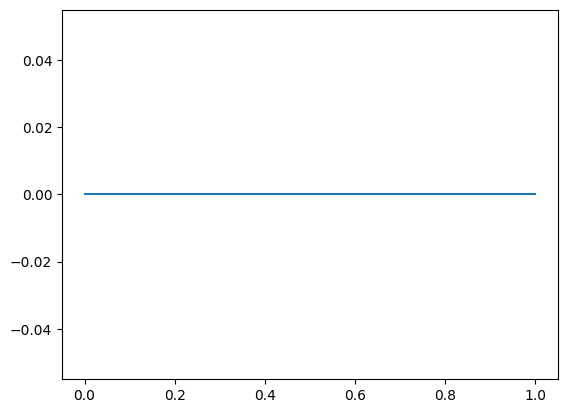

In [9]:
print(rewards)
plt.plot(rewards)